In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg.lapack import zggev
from scipy.linalg import block_diag
import pandas as pd
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from direct_effect_analysis import * 
from utils import *
from mvlearn.embed import GCCA
from pgmpy.estimators import PC
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, scale_x_continuous, labs, theme, facet_wrap, ggsave

In [2]:
algorithms = ['PCA', 'genCCA', 'OptiDet', 'Roy', 'RoyS']
B_conds = ['d', '1', '1/d', '1/d^2']
Sigma_conds = ['d', '1', '1/d', '1/d^2']
results = {B_cond:{Sigma_cond:{algo: {} for algo in algorithms } for Sigma_cond in Sigma_conds} for B_cond in B_conds} 

In [3]:
p, r, d, q, rk = 10, 10, 100, 1, 10
N = 4000
dimensions = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [4]:
a, b, c = 0.1, 0.1, 0.8
B = 1
for B_cond in tqdm(B_conds):
    for Sigma_cond in Sigma_conds:
        for algo in algorithms:
            # print(noise, algo)
            CORRS = []
            for d in dimensions:
                d = int(d)
                CORR = []
                for j in range(B):

                    # Generate parameters
                    _, A_z, beta, gamma = parameters(r, p, q, d, False)

                    if B_cond == 'd':
                        A_x = np.array([i for i in range(d)])[:, None].T
                    elif B_cond == '1':
                        A_x = np.array([1 for i in range(d)])[:, None].T
                    elif B_cond == '1/d':
                        A_x = np.array([1/(i+1) for i in range(d)])[:, None].T
                    elif B_cond == '1/d^2':
                        A_x = np.array([1/((i+1)**2) for i in range(d)])[:, None].T

                    if Sigma_cond == 'd':
                        Sigma = np.diag(np.array([i for i in range(d)]))
                    elif Sigma_cond == '1':
                        Sigma = np.identity(d)
                    elif Sigma_cond == '1/d':
                        Sigma = np.diag(np.array([1/(i+1) for i in range(d)]))
                    elif Sigma_cond == '1/d^2':
                        Sigma = np.diag(np.array([1/((i+1)**2) for i in range(d)]))


                    # Generate training and test data
                    X_train, Y_train, Z_train, Y_x_train = generate_data_Sigma(N, p, r, d, beta, gamma, A_x, A_z, Sigma, a=a, b=b, c=c)
                    dea = DirectEffectAnalysis(type=algo, alpha=1e-5)
                    dea.fit(X_train, Y_train, Z_train)
                    Y_hat = dea.transform(X_train, Y_train, Z_train)
                    corr = np.abs(np.corrcoef(Y_hat, Y_x_train[:,0])[0, 1])
                    
                    # Compute MSE for each iteration
                    CORR.append(corr)
                CORRS.append(CORR)
            # Append MSE for current sample size
            results[B_cond][Sigma_cond][algo] = CORRS

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:47<00:00, 11.98s/it]


/tmp/ipykernel_14602/1057132352.py:48: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


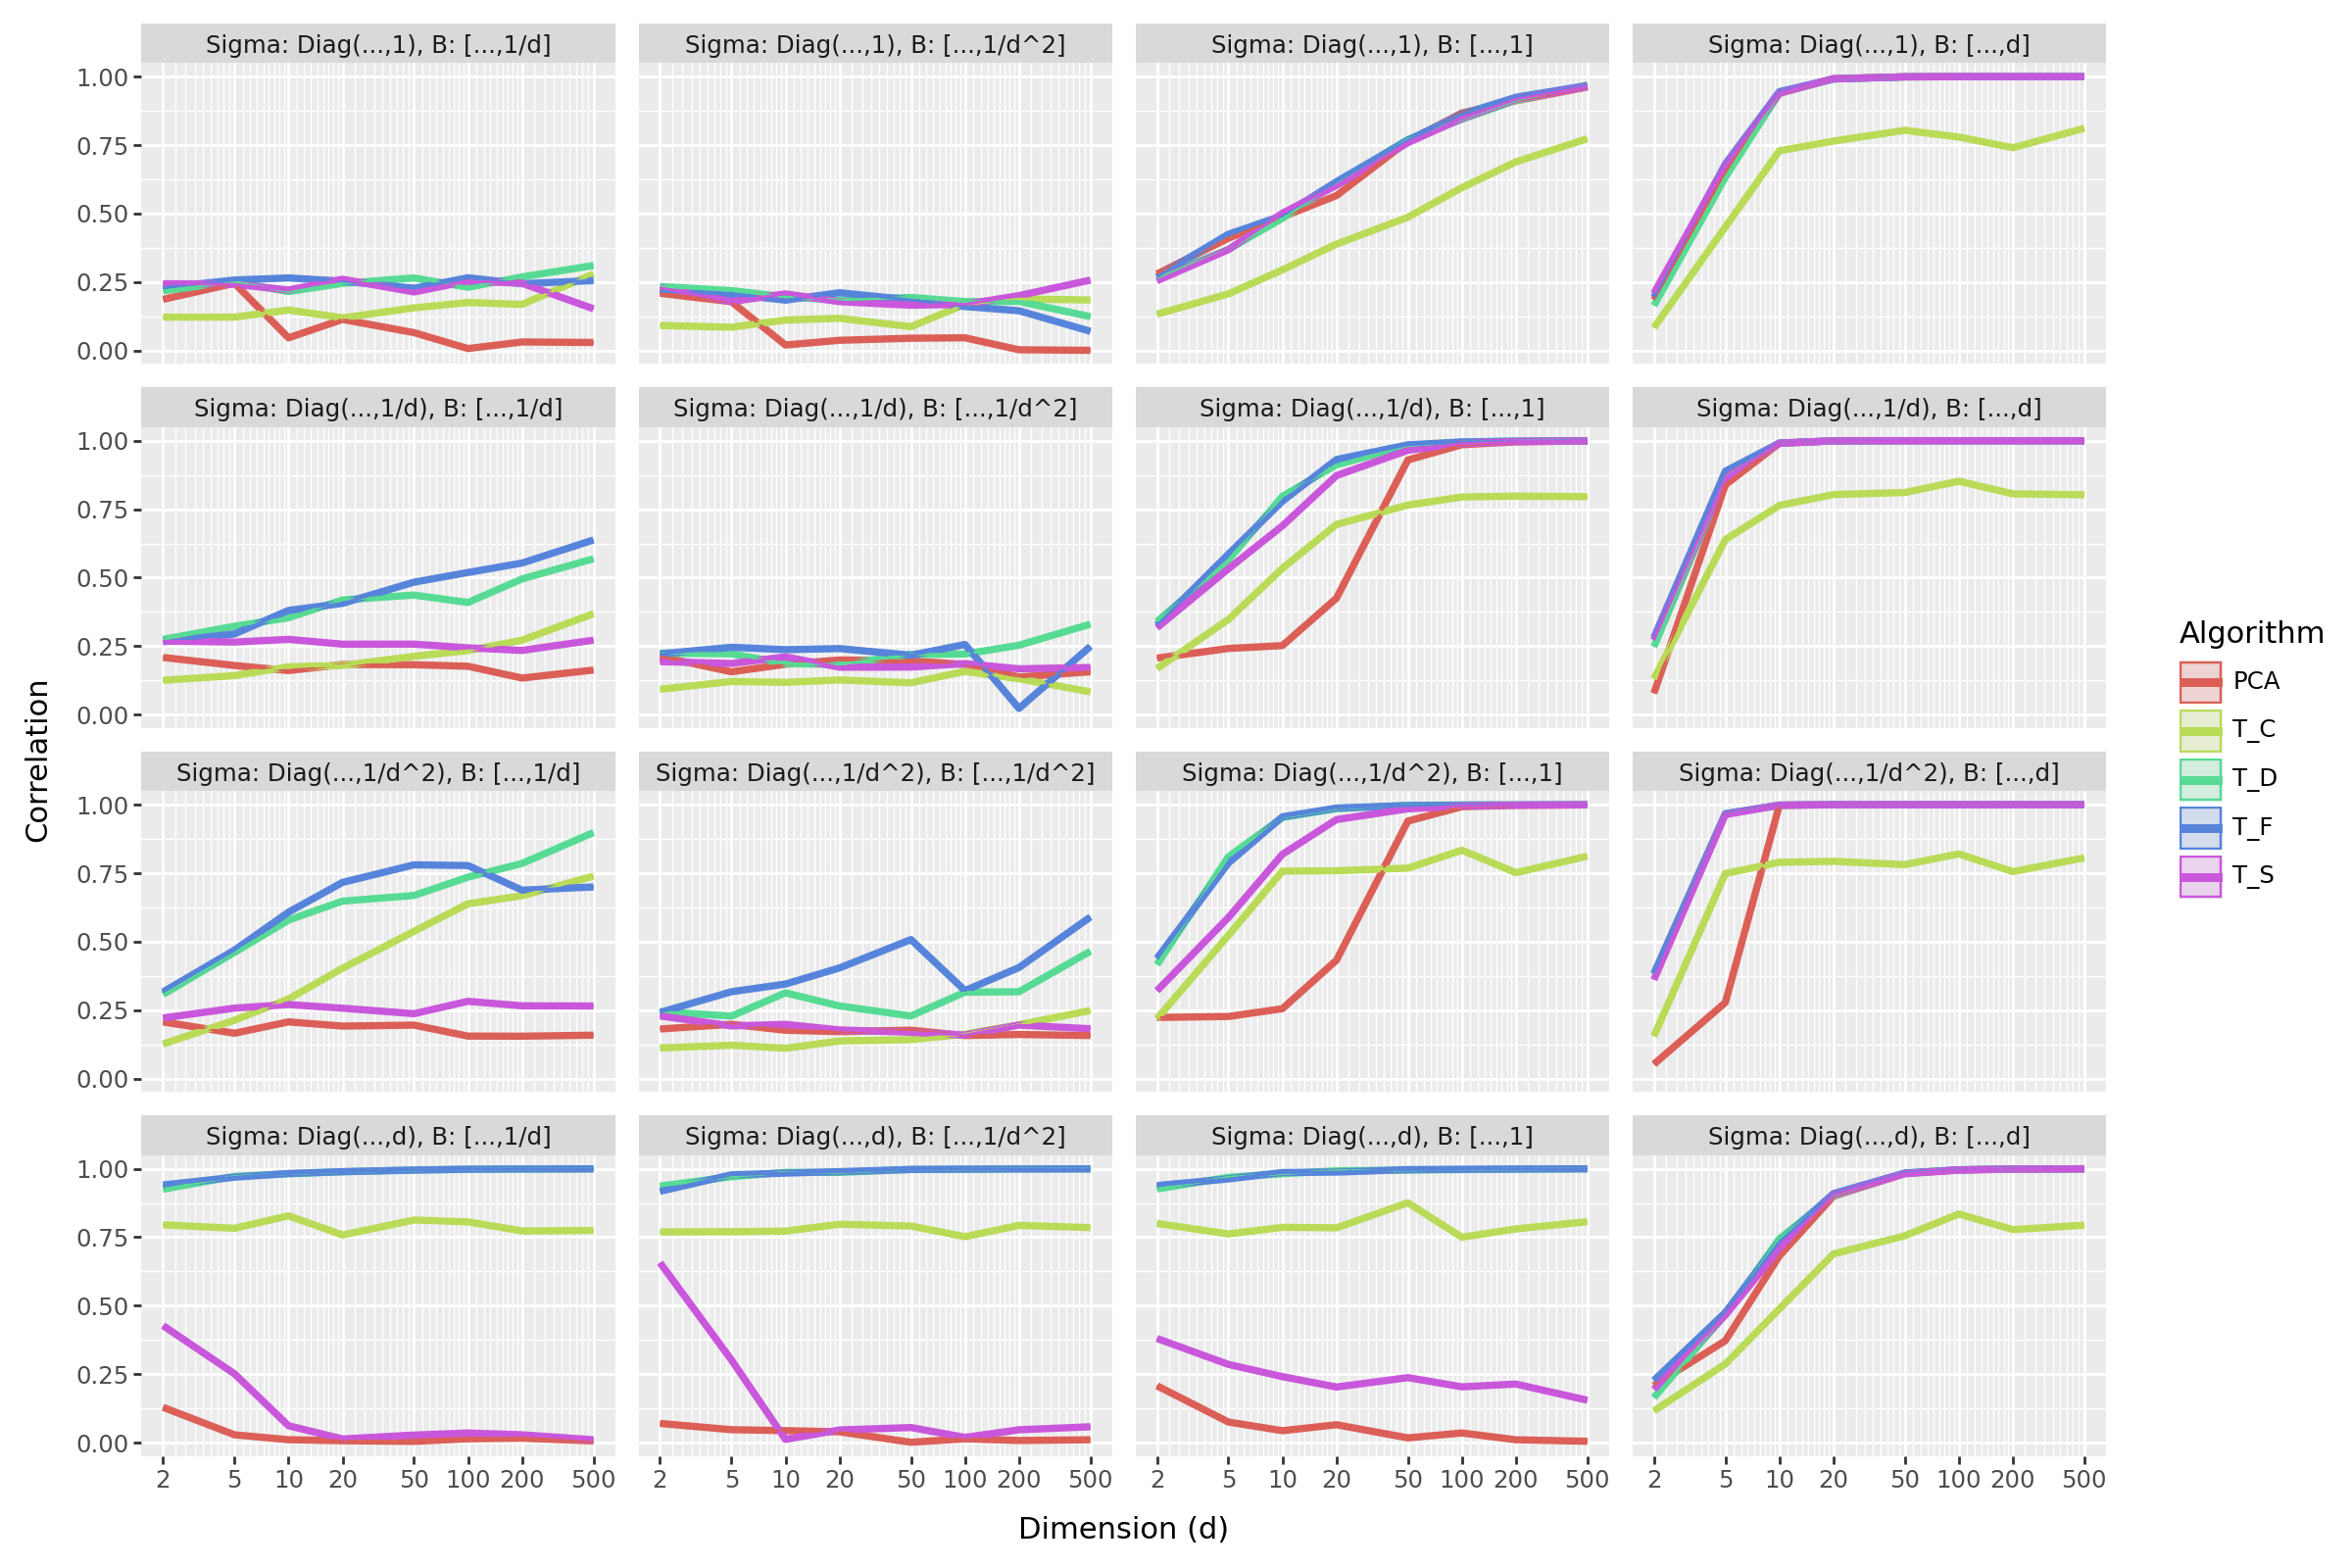

In [9]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, labs, facet_wrap, theme

# Assuming you have the following data structures
algo_names = {'PCA':'PCA', 'genCCA':'T_C', 'OptiDet':'T_D', 'Roy':'T_F', 'RoyS':'T_S'}
# results, B_conds, Sigma_conds, algorithms, dimensions are defined elsewhere

# Prepare data for ggplot
data = []
for B_cond in B_conds:
    for Sigma_cond in Sigma_conds:
        for algo in algorithms:
            algo_data = results[B_cond][Sigma_cond][algo]
            values = np.array(algo_data)
            median = np.percentile(values, 50, axis=1)
            lower = np.percentile(values, 5, axis=1)
            upper = np.percentile(values, 95, axis=1)
            
            for i, dim in enumerate(dimensions):
                data.append({
                    'Dimension': dim,
                    'Median': median[i],
                    'Lower': lower[i],
                    'Upper': upper[i],
                    'Algorithm': algo_names[algo],
                    'Sigma': Sigma_cond,
                    'B': B_cond  # Add weight name to the data
                })

# Create a DataFrame
df = pd.DataFrame(data)

# Create a new column for the facet label
df['Facet_Label'] = 'Sigma: Diag(...,' + df['Sigma'].astype(str) + '), B: [...,' + df['B'].astype(str) + ']'

# Plot using ggplot with logarithmic scale on the x-axis
p = (ggplot(df, aes(x='Dimension', y='Median', color='Algorithm', fill='Algorithm'))
     + geom_line(size=1.5)
     + geom_ribbon(aes(ymin='Lower', ymax='Upper'), alpha=0.2)
     + scale_x_log10(breaks=dimensions)  # Set specific x-axis ticks to log scale
     + labs(x='Dimension (d)', y='Correlation')
     + facet_wrap('~Facet_Label', ncol=4)  # Use the new Facet_Label for facets
     + theme(legend_position='right', figure_size=(12, 8))  # Set figure size
)

# Display the plot
print(p)


In [6]:
df

,Dimension,Median,Lower,Upper,Algorithm,Sigma,B,Facet_Label
0,2,0.208388,0.208388,0.208388,PCA,d,d,Sigma: Diag(d B: d
1,5,0.372362,0.372362,0.372362,PCA,d,d,Sigma: Diag(d B: d
2,10,0.681684,0.681684,0.681684,PCA,d,d,Sigma: Diag(d B: d
3,20,0.899680,0.899680,0.899680,PCA,d,d,Sigma: Diag(d B: d
4,50,0.982576,0.982576,0.982576,PCA,d,d,Sigma: Diag(d B: d
...,...,...,...,...,...,...,...,...
635,20,0.177737,0.177737,0.177737,RoyS,1/d^2,1/d^2,Sigma: Diag(1/d^2 B: 1/d^2
636,50,0.169163,0.169163,0.169163,RoyS,1/d^2,1/d^2,Sigma: Diag(1/d^2 B: 1/d^2
637,100,0.159026,0.159026,0.159026,RoyS,1/d^2,1/d^2,Sigma: Diag(1/d^2 B: 1/d^2
638,200,0.195496,0.195496,0.195496,RoyS,1/d^2,1/d^2,Sigma: Diag(1/d^2 B: 1/d^2
